<a href="https://colab.research.google.com/github/saquibali7/VideoFramePrediction/blob/main/FinalFramePrediction10_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs
import imageio
from tensorflow_docs.vis import embed

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path='/content/drive/MyDrive/t4_videos_GAN'
data = os.listdir(data_path)

In [ ]:
print(len(data))

488


In [ ]:
frames = list()
counting=0
for idx in range(0,200):
  temp=list()
  cap = cv2.VideoCapture(os.path.join(data_path,data[idx]))
  while(cap.isOpened()):
    ret, frame = cap.read()
    try:
      img = cv2.resize(frame, (256, 256))
      temp.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break   
  count=0
  while(count+10 <= len(temp)):
    frames.append(temp[count:count+10])
    count = count+10  
    counting+=1
  cap.release()
  cv2.destroyAllWindows()

In [ ]:
print(counting)

978


In [ ]:
frames = np.array(frames)
print(frames.shape)

(978, 10, 256, 256, 3)


In [ ]:
print(frames.shape)

(978, 10, 256, 256, 3)


In [ ]:
def return_frames(idx):
  frames=list()
  cap = cv2.VideoCapture(os.path.join(data_path,data[idx]))
  while(cap.isOpened()):
    ret, frame = cap.read()
    try:
      img = cv2.resize(frame, (256, 256))
      frames.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break   
  frames = np.array(frames)  
  cap.release()
  cv2.destroyAllWindows()
  return frames



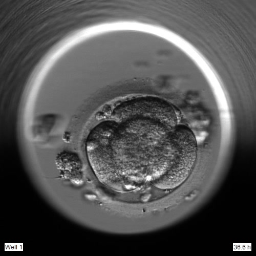

In [ ]:
import random
idx = random.randint(0,len(data))
frame = return_frames(idx)
to_gif(frame/255.0)

In [ ]:
frames = (frames/255.0).astype(np.float16)

In [ ]:
indexes = np.arange(frames.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * frames.shape[0])]
val_index = indexes[int(0.9 * frames.shape[0]) :]
train_dataset = frames[train_index]
val_dataset = frames[val_index]

In [ ]:
def create_dataset(frames):
  x = frames[:, 0:frames.shape[1]-1, :, :]
  y = frames[: , 1:frames.shape[1], :, :]
  return x, y

In [ ]:
train_x, train_y = create_dataset(train_dataset)
val_x, val_y = create_dataset(val_dataset)

In [ ]:
to_gif(train_x[0].astype(np.float32))

In [ ]:
input = layers.Input(shape=(None, *train_x.shape[2:]))
x = layers.ConvLSTM2D(
    filters = 64, 
    kernel_size=(5,5),
    padding="same",
    return_sequences=True,    
    activation="relu"
    )(input)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size=(3,3),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size=(3,3),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size = (1,1),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size = (1,1),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)    

x = layers.Conv3D(
    filters = 3, 
    kernel_size = (3, 3, 3),
    activation = "sigmoid",
    padding = "same"
    )(x)

model = keras.models.Model(input, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
  optimizer=keras.optimizers.Adam(),
)

NameError: ignored

In [ ]:
model.summary()

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience = 5)

In [ ]:
import datetime

%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [ ]:
# model.save('/content/drive/MyDrive/framePrediction/model/frame41')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/framePrediction/model/frame41')

In [ ]:
import random
import matplotlib.pyplot as plt
from math import log10, sqrt
from tqdm import tqdm


def PSNR(expected,Predicted): 
    mse = np.mean((expected - Predicted) ** 2) 
    if(mse == 0): 
        return 0,100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return mse,psnr

In [ ]:
def normalize(sample):
    MIN_H = sample.min()
    MAX_H = sample.max()
    return (sample - MIN_H)/(MAX_H-MIN_H)

In [ ]:
def generate_images(frames):
  expected = frames[-1, ...]/255.0
  frames = frames[0:9, :, :, :]/255.0
  out = model.predict(np.expand_dims(frames, axis = 0))
  out = np.squeeze(out, axis = 0)
  out = np.expand_dims(out[-1, ...], axis = 0)
  out = tf.squeeze(out,axis = 0)
  expected = expected.astype(np.float32)

  plt.figure(figsize=(15,15))
  title = ['Ground Truth','Predicted']
  display_list = [expected,out]
  for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')

  plt.show()
  mse,psnr = PSNR(expected*255,out*255)
  print("MSE value is {}".format(mse))
  print("PNSR value is {}".format(psnr))
  expected = expected.astype(np.float32)
  ssim = tf.image.ssim(expected, out, max_val=1, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
  print("SSIM value is {}".format(ssim))

391
(10, 256, 256, 3)
1/1 [==============================] - 3s 3s/step


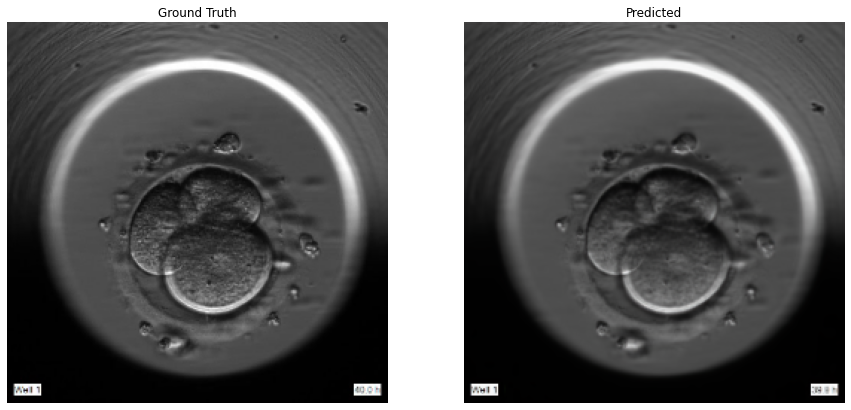

MSE value is 28.684814453125
PNSR value is 33.55428315861393
SSIM value is 0.9345464706420898


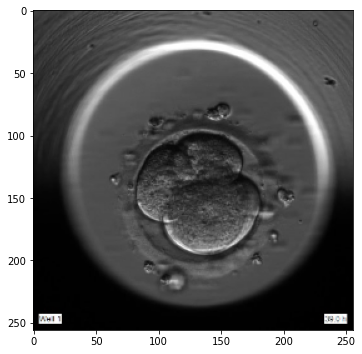

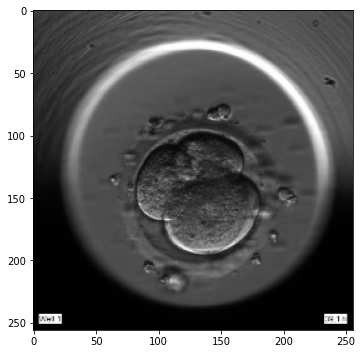

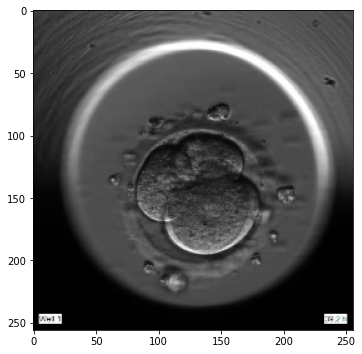

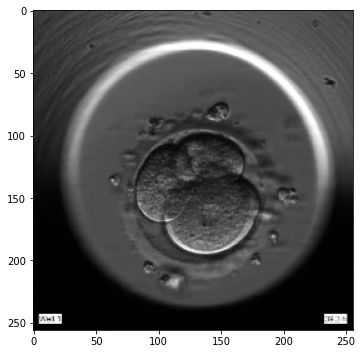

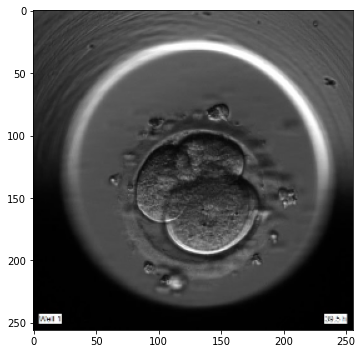

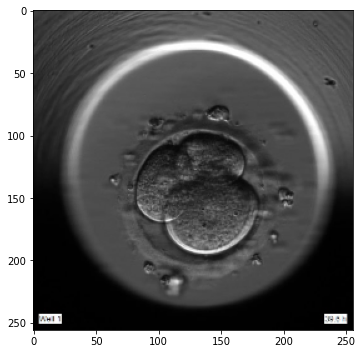

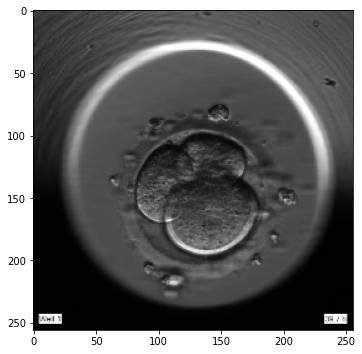

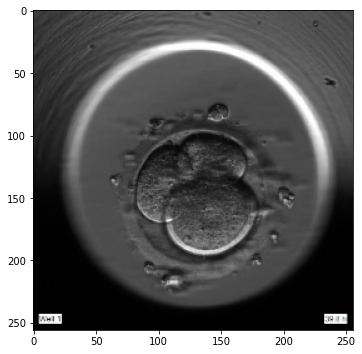

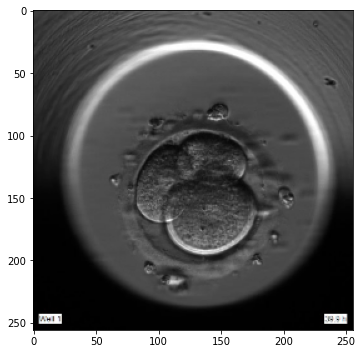

In [ ]:
idx = random.randint(200,len(data))
frames = return_frames(idx)
print(idx)
frames = frames[0:10, :, :, :]
print(frames.shape)
generate_images(frames)
for i in range(9):
  plt.figure(figsize=(20, 20))
  plt.subplot(3,3,i+1)
  expected = frames[i].astype(np.float32)
  plt.imshow(expected/255.0)


In [ ]:
def generate_images(frames):
  expected = frames[-1, ...]
  input_frames = frames[0:9, :, :, :]
  out = model.predict(np.expand_dims(input_frames, axis = 0))
  out = np.squeeze(out, axis = 0)
  output=out
  out = np.expand_dims(out[-1, ...], axis = 0)
  out = tf.squeeze(out,axis = 0)
  expected = expected.astype(np.float32)
  print(output.shape)

  for i in range(9):
    exp = frames[i+1].astype(np.float32)
    ssim = tf.image.ssim(exp,output[i], max_val=1, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    mse,psnr = PSNR(exp*255,output[i]*255)
    print("sim , mse and psnr for ",i+1, " th frame s is {}".format(ssim), mse,psnr)

  plt.figure(figsize=(30,50))
  title = ['Ground Truth','Predicted']
  display_list = [expected,out]
  count1=0
  count2=0
  for i in range(18):
    plt.subplot(9,2,i+1)
    if i==0 or i==1:
      plt.title(title[i])
    if i%2==0:
      plt.imshow(frames[count1+1])
      count1+=1
    else :
      plt.imshow(output[count2])
      count2+=1
    plt.axis('off')

  plt.show()
  mse,psnr = PSNR(expected*255,out*255)
  print("MSE value is {}".format(mse))
  print("PNSR value is {}".format(psnr))
  expected = expected.astype(np.float32)
  ssim = tf.image.ssim(expected, out, max_val=1, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
  print("SSIM value is {}".format(ssim))

481
(10, 256, 256, 3)
1/1 [==============================] - 0s 446ms/step
(9, 256, 256, 3)
sim , mse and psnr for  1  th frame s is 0.9910964369773865 4.9014525 41.22755558959539
sim , mse and psnr for  2  th frame s is 0.9925839900970459 3.8031604 42.32935715193307
sim , mse and psnr for  3  th frame s is 0.9924535155296326 3.9273784 42.18977611853788
sim , mse and psnr for  4  th frame s is 0.9927363991737366 3.9277134 42.189405711302484
sim , mse and psnr for  5  th frame s is 0.9931471943855286 4.108681 41.9937791578802
sim , mse and psnr for  6  th frame s is 0.9934794306755066 3.977811 42.13436205760055
sim , mse and psnr for  7  th frame s is 0.9937825202941895 4.2000575 41.898251241339956
sim , mse and psnr for  8  th frame s is 0.9944913387298584 4.3178368 41.7781414133447
sim , mse and psnr for  9  th frame s is 0.9202200770378113 41.610798 31.938743174502964


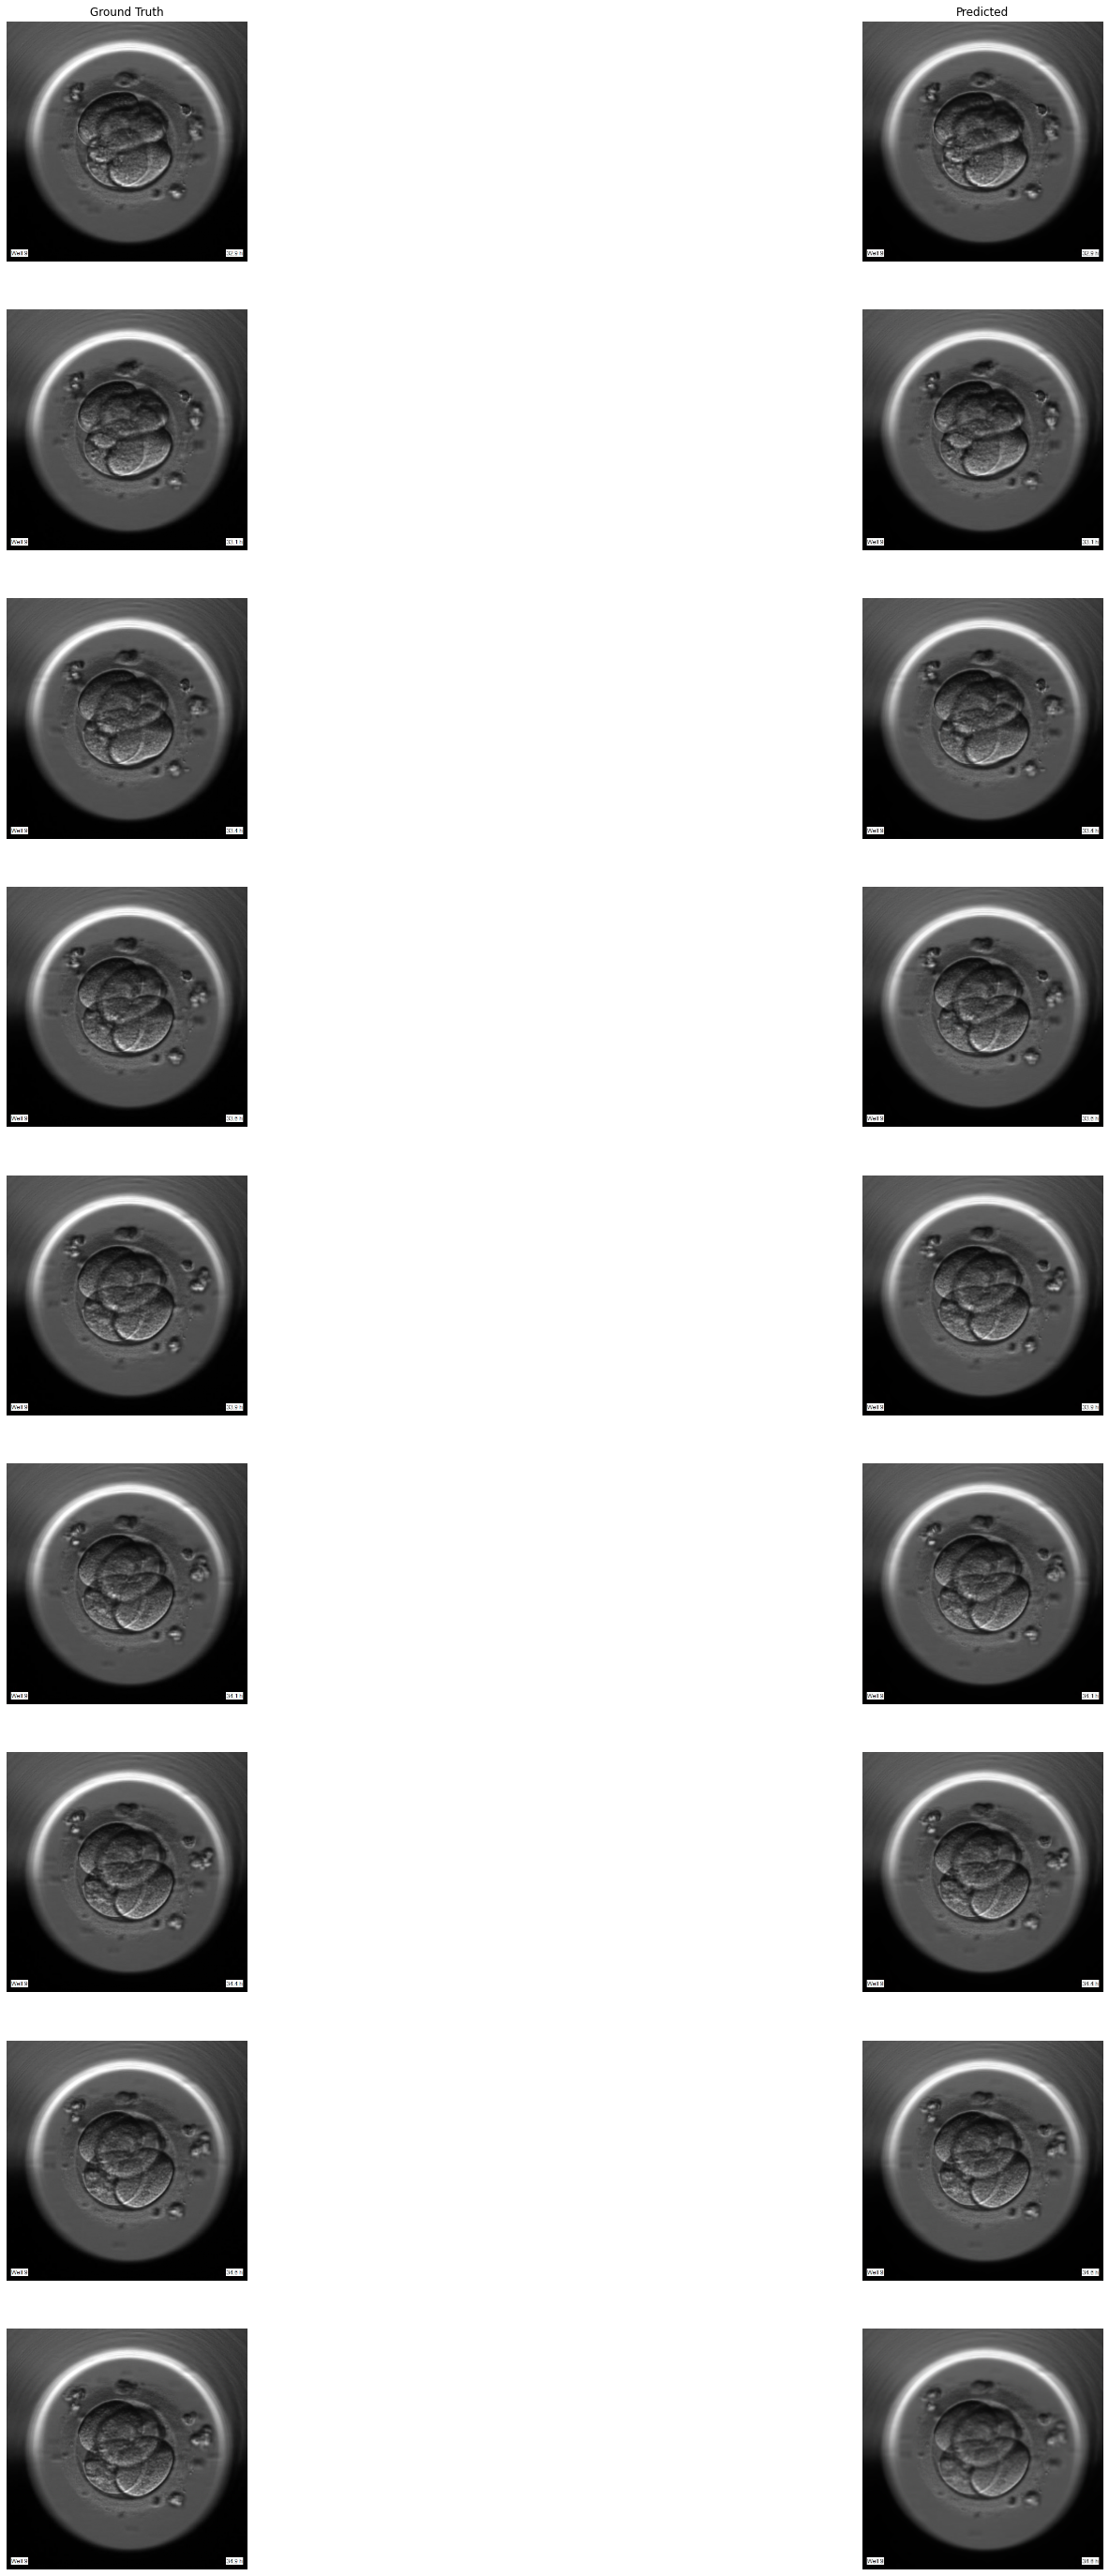

MSE value is 41.61079788208008
PNSR value is 31.938743174502964
SSIM value is 0.9202200770378113


In [ ]:
idx = random.randint(200,len(data))
frames = return_frames(idx)
print(idx)
frames = frames[0:10, :, :, :]
print(frames.shape)
frames = normalize(frames)
generate_images(frames)


(12, 256, 256, 3)
(9, 256, 256, 3)
1/1 [==============================] - 0s 482ms/step
(9, 256, 256, 3)
1/1 [==============================] - 0s 381ms/step
(9, 256, 256, 3)
1/1 [==============================] - 0s 380ms/step
(9, 256, 256, 3)
sim , mse and psnr for  0  th frame s is 0.9562137126922607 22.343544 34.639283012947146
sim , mse and psnr for  1  th frame s is 0.925199031829834 34.898346 32.70275517375737
sim , mse and psnr for  2  th frame s is 0.9002320170402527 50.34865 31.110925143062836


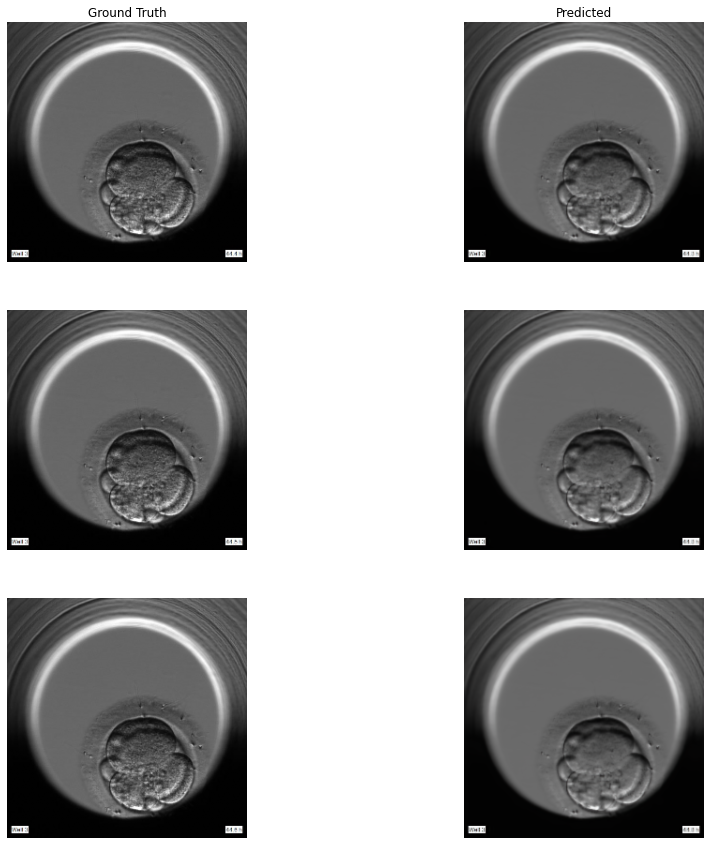

In [ ]:
def generate_images(frames):
  output=[]
  input_idx = 9
  input_frames = frames[0:input_idx, :, :, :]
  print(input_frames.shape)
  for _ in range(3):
    input_frames = np.expand_dims(input_frames, axis = 0)
    out = model.predict(input_frames)
    out = np.squeeze(out, axis = 0)
    output.append(out[-1])
    input_frames=out
    print(input_frames.shape)

  total_output=out

  for i in range(3):
    exp = frames[input_idx+i].astype(np.float32)
    ssim = tf.image.ssim(exp,output[i], max_val=1, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    mse,psnr = PSNR(exp*255,output[i]*255)
    print("sim , mse and psnr for ",i, " th frame s is {}".format(ssim), mse,psnr)

  plt.figure(figsize=(15,15))
  title = ['Ground Truth','Predicted']
  count1=0
  count2=0
  display_list = [expected,out]
  for i in range(6):
    plt.subplot(3,2,i+1)
    if i==0 or i==1:
      plt.title(title[i])
    if i%2==0:
      plt.imshow(frames[input_idx+count1])
      count1+=1
    else :
      plt.imshow(output[count2])
      count2+=1  
    plt.axis('off')


idx = random.randint(200,len(data))
frames = return_frames(idx)
frames = frames[0:12, :, :, :]
frames = normalize(frames)
print(frames.shape)
generate_images(frames)

  